In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask


In [2]:
cluster = PBSCluster(
    cores=1,
    memory="60GB",
    project='pangeo',
    processes=1,
    walltime='04:00:00',
    local_directory='$TMPDIR')
cluster

/home/ad/alberta/git/conda-pack/pytide/lib/python3.6/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34874 instead
  http_address["port"], self.http_server.port


PBSCluster('tcp://10.120.43.24:32978', workers=0, threads=0, memory=0 B)

In [3]:
cluster.scale(40)

In [4]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.43.24:32978 Dashboard: http://10.120.43.24:34874/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
import zarr
import netCDF4
import pytide
import xarray as xr
import os
import numpy as np

In [6]:
%%time
root = "/work/ALT/odatis/eNATL60/BLBT02/gridT-2D/"
files = [
    os.path.join(root, item) for item in os.listdir(root) if item.endswith(".nc")]

drop_vars = [
    'nav_lat',
    'nav_lon',
    'somxl010',
    'sosaline',
    'sosstsst']

# these are variables I want to drop while running `open_mfdataset` but then add back later
extra_coord_vars = ['time_counter', 'y', 'x']
extra_coord_vars = []

chunks = dict(time_counter=1)

open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
                   chunks=chunks, decode_cf=True, concat_dim="time_counter") #, combine='nested')
ds = xr.open_mfdataset(files, combine='nested',parallel=True, **open_kwargs)


CPU times: user 4.12 s, sys: 227 ms, total: 4.35 s
Wall time: 12.4 s


In [9]:
START_DATE = np.datetime64('2009-07-01')
END_DATE = np.datetime64('2009-07-31')
time_series=ds['time_counter']
period = (time_series >= START_DATE) & (time_series <= END_DATE)


In [10]:
period

,Array,Chunk
Bytes,93.50 kB,8 B
Shape,"(11688,)","(1,)"
Count,23863 Tasks,11688 Chunks
Type,datetime64[ns],numpy.ndarray


In [11]:
time=time_series[period]


In [12]:
time

,Array,Chunk
Bytes,5.76 kB,8 B
Shape,"(720,)","(1,)"
Count,24583 Tasks,720 Chunks
Type,datetime64[ns],numpy.ndarray


In [13]:
ssh=ds.sossheig[period]

In [14]:
ssh

,Array,Chunk
Bytes,113.78 GB,158.02 MB
Shape,"(720, 4729, 8354)","(1, 4729, 8354)"
Count,24583 Tasks,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.76 kB,8 B
Shape,"(720,)","(1,)"
Count,24583 Tasks,720 Chunks
Type,datetime64[ns],numpy.ndarray


In [15]:
t=time.values

In [16]:
wt = pytide.WaveTable()
wt = pytide.WaveTable(["M2", "S2", "N2", "O1", "K1"])

In [17]:
%%time
f, vu = wt.compute_nodal_modulations(t)

CPU times: user 662 µs, sys: 993 µs, total: 1.66 ms
Wall time: 1.41 ms


In [18]:
def dask_array_rechunk(da, axis=0):
    """Search for the optimal block cutting without modifying the axis 'axis'
    in order to optimize its access in memory."""
    nblocks = 1
    
    def calculate_chuncks_size(chunks, size):
        result = np.array(chunks).prod() * size
        return result / (1000**2)
       
    while True:
        chunks = []
        div = int(np.sqrt(nblocks))
        for index, item in enumerate(da.chunks):
            chunks.append(np.array(item).sum() * (div if index == axis else 1))
        chunks = tuple(item // div for index, item in enumerate(chunks))
        chuncks_size = calculate_chuncks_size(chunks, da.dtype.itemsize)
        if chuncks_size > 100 and chuncks_size < 150:
            return chunks
        nblocks += 1

In [19]:
dask_array_rechunk(ssh)

(720, 168, 298)

In [20]:
ssh_rechunk = ssh.chunk(dask_array_rechunk(ssh))

In [21]:
ssh_rechunk

<xarray.DataArray 'sossheig' (time_counter: 720, y: 4729, x: 8354)>
dask.array<rechunk-merge, shape=(720, 4729, 8354), dtype=float32, chunksize=(720, 168, 298), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(720,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-07-06T00:30:00 ... 2009-07-02T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [22]:
def _apply_along_axis(arr, func1d, func1d_axis, func1d_args, func1d_kwargs):
    """Wrap apply_along_axis"""
    return np.apply_along_axis(func1d, func1d_axis, arr, *func1d_args,
                                  **func1d_kwargs)


def apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """Apply the harmonic analysis to 1-D slices along the given axis."""
    arr = dask.array.core.asarray(arr)

    # Validate and normalize axis.
    arr.shape[axis]
    axis = len(arr.shape[:axis])

    # Rechunk so that analyze is applied over the full axis.
    arr = arr.rechunk(arr.chunks[:axis] + (arr.shape[axis:axis + 1], ) +
                      arr.chunks[axis + 1:])

    # Test out some data with the function.
    test_data = np.ones(args[0].shape[1], dtype=arr.dtype)
    test_result = np.array(func1d(test_data, *args, **kwargs))

    # Map analyze over the data to get the result
    # Adds other axes as needed.
    result = arr.map_blocks(
        _apply_along_axis,
        name=dask.utils.funcname(func1d) + '-along-axis',
        dtype=test_result.dtype,
        chunks=(arr.chunks[:axis] + test_result.shape + arr.chunks[axis + 1:]),
        drop_axis=axis,
        new_axis=list(range(axis, axis + test_result.ndim, 1)),
        func1d=func1d,
        func1d_axis=axis,
        func1d_args=args,
        func1d_kwargs=kwargs,
    )

    return result

In [23]:
future = apply_along_axis(pytide.WaveTable.harmonic_analysis, 0, ssh_rechunk,
                          *(f, vu))

In [24]:
%%time
analysis = future.compute()

In [26]:
analysis.shape

(5, 4729, 8354)

In [27]:
amp = np.absolute(analysis[0, :, :])
pha = np.angle(analysis[0, :, :], deg=True)

Text(0.5, 1.0, 'M2 amplitude (m)')

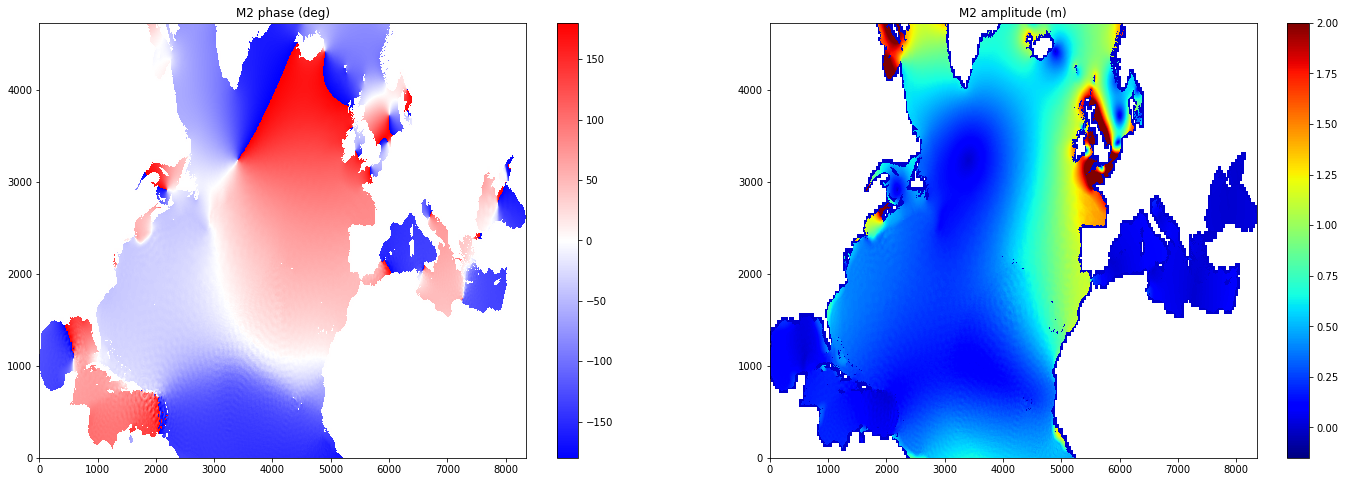

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax_pha, ax_amp) = plt.subplots(1, 2, figsize=(24, 8))

c = ax_pha.pcolormesh(pha, vmin=-180, vmax=180, cmap='bwr')
fig.colorbar(c, ax=ax_pha)
ax_pha.set_title("M2 phase (deg)")

c = ax_amp.pcolormesh(amp, vmin=-0.15, vmax=2, cmap='jet')
fig.colorbar(c, ax=ax_amp)
ax_amp.set_title("M2 amplitude (m)")

In [30]:
nwaves, ni, nj = analysis.shape
tide = wt.tide_from_mapping(
    time[0].astype('datetime64[s]').astype('float64'),
    analysis.reshape(nwaves, ni*nj)).reshape(ni, nj)

In [31]:
tide.shape

(4729, 8354)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.pcolormesh(ssh[0], cmap='jet',vmin=2, vmax=2)
ax1.set_title("Total SSH")
ax2.pcolormesh(ssh[0]-tide, cmap='jet',vmin=2, vmax=2)
ax2.set_title("SSH corrected")
ax3.pcolormesh(tide, cmap='jet',vmin=2, vmax=2)
ax3.set_title("Tide estimated")
#plt.colorbar()